# Tomo_2_map
## Tomographic mapping notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

Now, all the grains are indexed thanks to the first notebook, but their position is all the same.
This notebook aims at reconstructing grain shapes and positions from the grain orientations found in the first notebook

This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

The notebooks are written with all the parameters in the first cell. 
We will see how to tune these parameters along the notebook.

For now, change : 
1. the dataset name (`dset_path`)
2. the phase name (`phase_str`)

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( os.path.join( os.environ['HOME'],'Code', 'Tutorial', 'SCRIPTS'), 'ImageD11' )# ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = '../FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5'

# which phase to index
phase_str = 'Fe'

# peak filtration parameters
cf_strong_frac = 0.993
cf_strong_dstol = 0.005

# If the sinograms are only half-sinograms (we scanned dty across half the sample rather than the full sample), set the below to true:
is_half_scan = False
# If we did halfmask, choose the radius to mask in the centre of the reconstruction (normally hot pixels)
halfmask_radius = 25

# assign peaks to the grains with hkl tolerance peak_assign_tol
peak_assign_tol = 0.05

# We can interactively draw a mask
draw_mask_interactive = True
# or we can threshold with Otsu, or a manual threshold value:
# e.g. manual_threshold = 0.006
manual_threshold = None

# tolerance for building sinograms from assigned peaks
hkltol = 0.25

# We can optionally correct each row of the sinogram by the ring current of that rotation
# This helps remove artifacts in the reconstruction
correct_sinos_with_ring_current = True
first_tmap_cutoff_level = 0.4

# how many iterations for Astra reconstruction?
niter = 500

second_tmap_cutoff_level = 0.05

# Setting path via: 
sys.path.insert(0, /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11 )


# Running from: /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/__init__.py


In [4]:
import concurrent.futures

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tqdm.notebook import tqdm
from ImageD11 import cImageD11
from ImageD11.peakselect import select_ring_peaks_by_intensity
import ImageD11.sinograms.dataset
from ImageD11.sinograms.sinogram import GrainSinogram, read_h5, write_h5, get_2d_peaks_from_4d_peaks
from ImageD11.sinograms.roi_iradon import run_iradon
from ImageD11.sinograms.tensor_map import TensorMap
from ImageD11.sinograms.geometry import sino_shift_and_pad
import ImageD11.nbGui.nb_utils as utils
from ImageD11.nbGui.draw_mask import InteractiveMask, threshold_mask

# %matplotlib ipympl

# Load data
1. The dataset
2. The phases
3. The segmented peaks
4. The indexed grains

## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases

All the phases should be specified in the parameter file.
We can access the unit cells via `ds.phases.unitcells`

In [6]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'B2': B2 | [ 3.8867  3.8867  3.8867 90.     90.     90.    ] | 221,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [7]:
ucell = ds.phases.unitcells[phase_str]
print(ucell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229


## Peaks
Loading the peaks that have beem segmented in @@@ref to 0_segmentation@@@ as a columnfile (*cf_4d*)

In [8]:
cf_4d = ds.get_cf_4d()
ds.update_colfile_pars(cf_4d)
ucell.makerings(cf_4d.ds.max())
print(f"Read {cf_4d.nrows} 4D peaks")

Loading existing colfile from /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_4d.h5
Reading your columnfile in hdf format


Read 1486660 4D peaks


## Grains

In [9]:
grains = ds.get_grains_from_disk(phase_str)
grainsinos = [GrainSinogram(g, ds) for g in grains]
utils.get_rgbs_for_grains(grains)
for grain_label, g in enumerate(grains):
    g.gid = grain_label
print(f"{len(grains)} grains imported")

Adding reference unitcells from self.phases


51 grains imported


The inverse polar figure of all grains are represented as colored dots. If the sample is highly textured, it should be visible at this point.

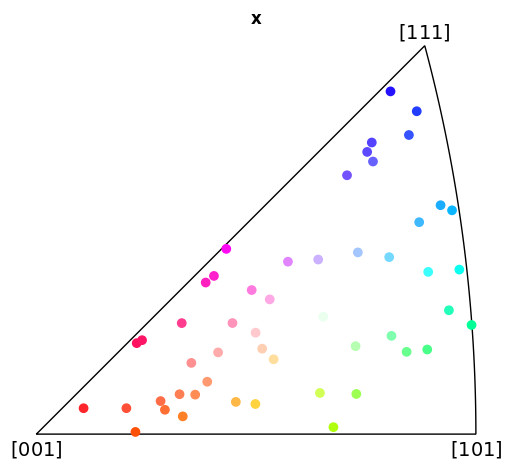

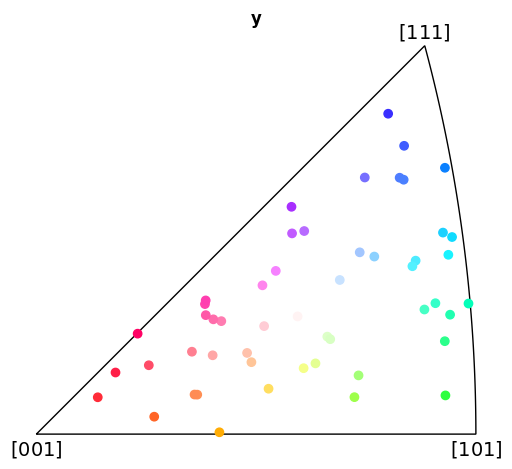

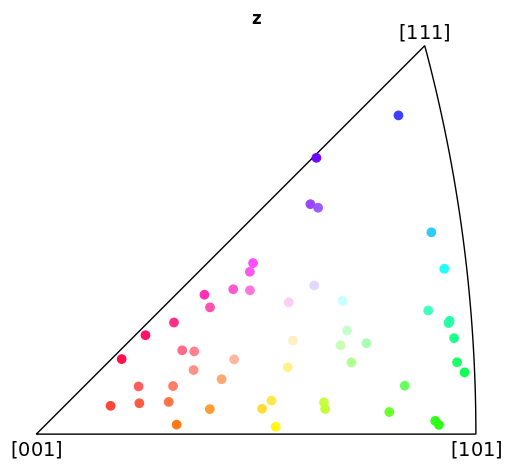

In [10]:
utils.plot_all_ipfs(grains)

# Filtration
Here we are filtering our peaks (`cf_4d`) to select only the strongest ones for mapping purposes!
This time, we don't clip via `dsmax`, because we need the higher-angle projections to get a complete sinograms of each grains.  

1. We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
2. We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.
  
- `cf_strong_dstol`: The tolerance in $d^{*}$ between a predicted reflection and a peak.  
- `cf_strong_frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

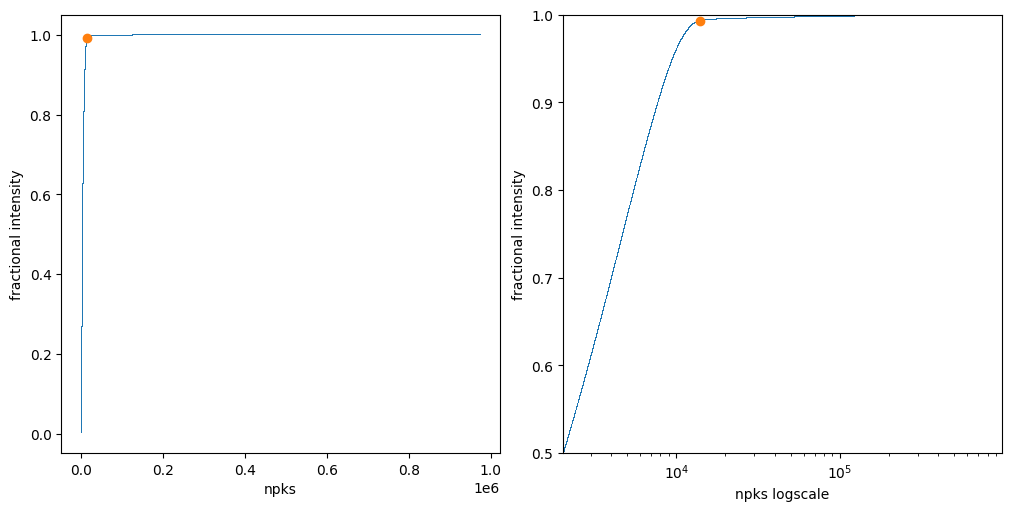

Filtered 14031 peaks from 1486660


In [11]:
cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=cf_strong_frac, dstol=cf_strong_dstol, dsmax=cf_4d.ds.max(), ucell=ucell, doplot=0.5)

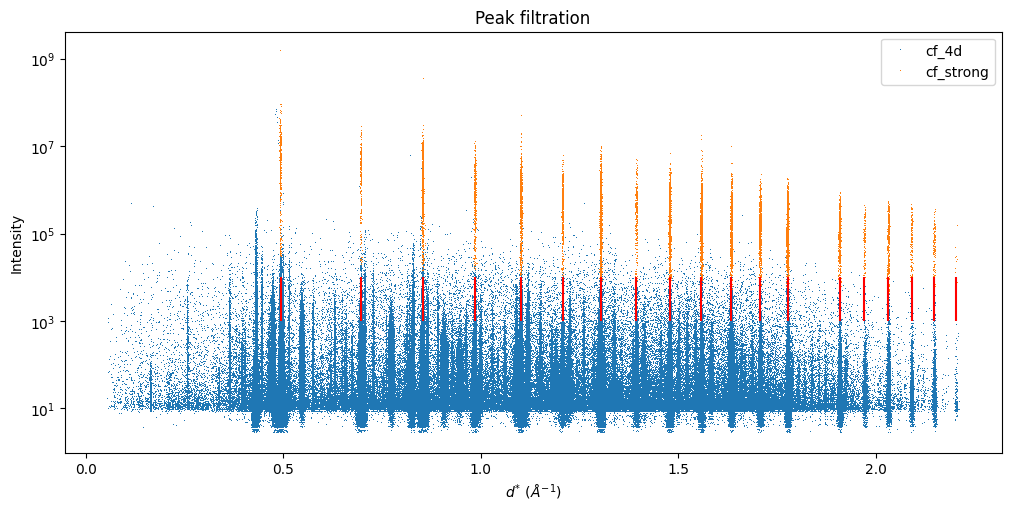

In [12]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_4d.ds[::skip], cf_4d.sum_intensity[::skip],',', label='cf_4d')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='cf_strong')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Peak assignment

All these strong peaks are now assigned to the grains. 

- `peak_assign_tol` defines the tolerance within which a peak belongs to a grain or not. If this tolerance is too high, the sinograms become noisy.

In [13]:
utils.assign_peaks_to_grains(grains, cf_strong, peak_assign_tol)
for grain_label, g in enumerate(grains):
    g.gid = grain_label
    g.npks_4d = np.sum(cf_strong.grain_id == grain_label)

Scoring and assigning 51 grains


  0%|          | 0/51 [00:00<?, ?it/s]

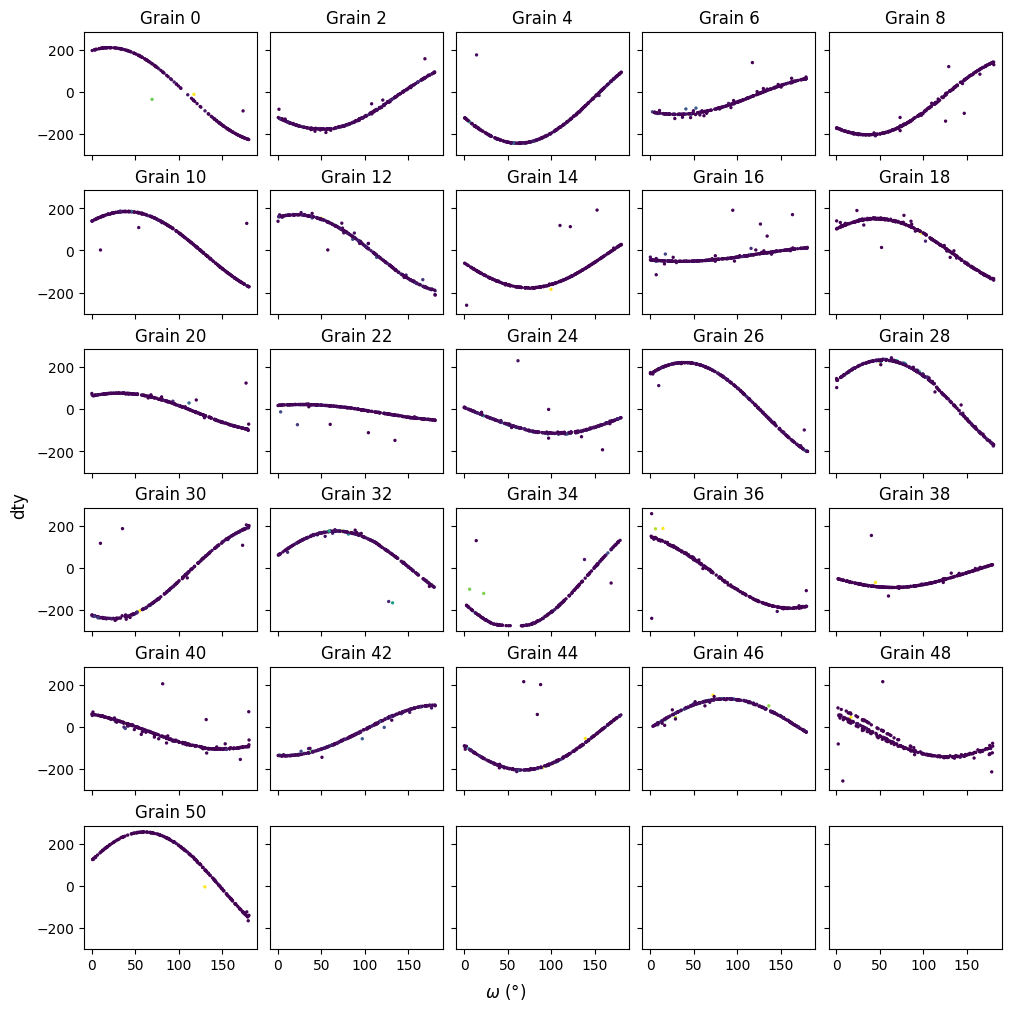

In [14]:
utils.plot_grain_sinograms(grains, cf_strong, min(len(grains), 25))

# Grain position refinement

With all these new peaks, the position of the center of masse of each grain is computed and refined. The overall shape of the sample should be distinguishable.

In [15]:
for grain_label, gs in enumerate(grainsinos):
    gs.update_lab_position_from_peaks(cf_strong, grain_label)

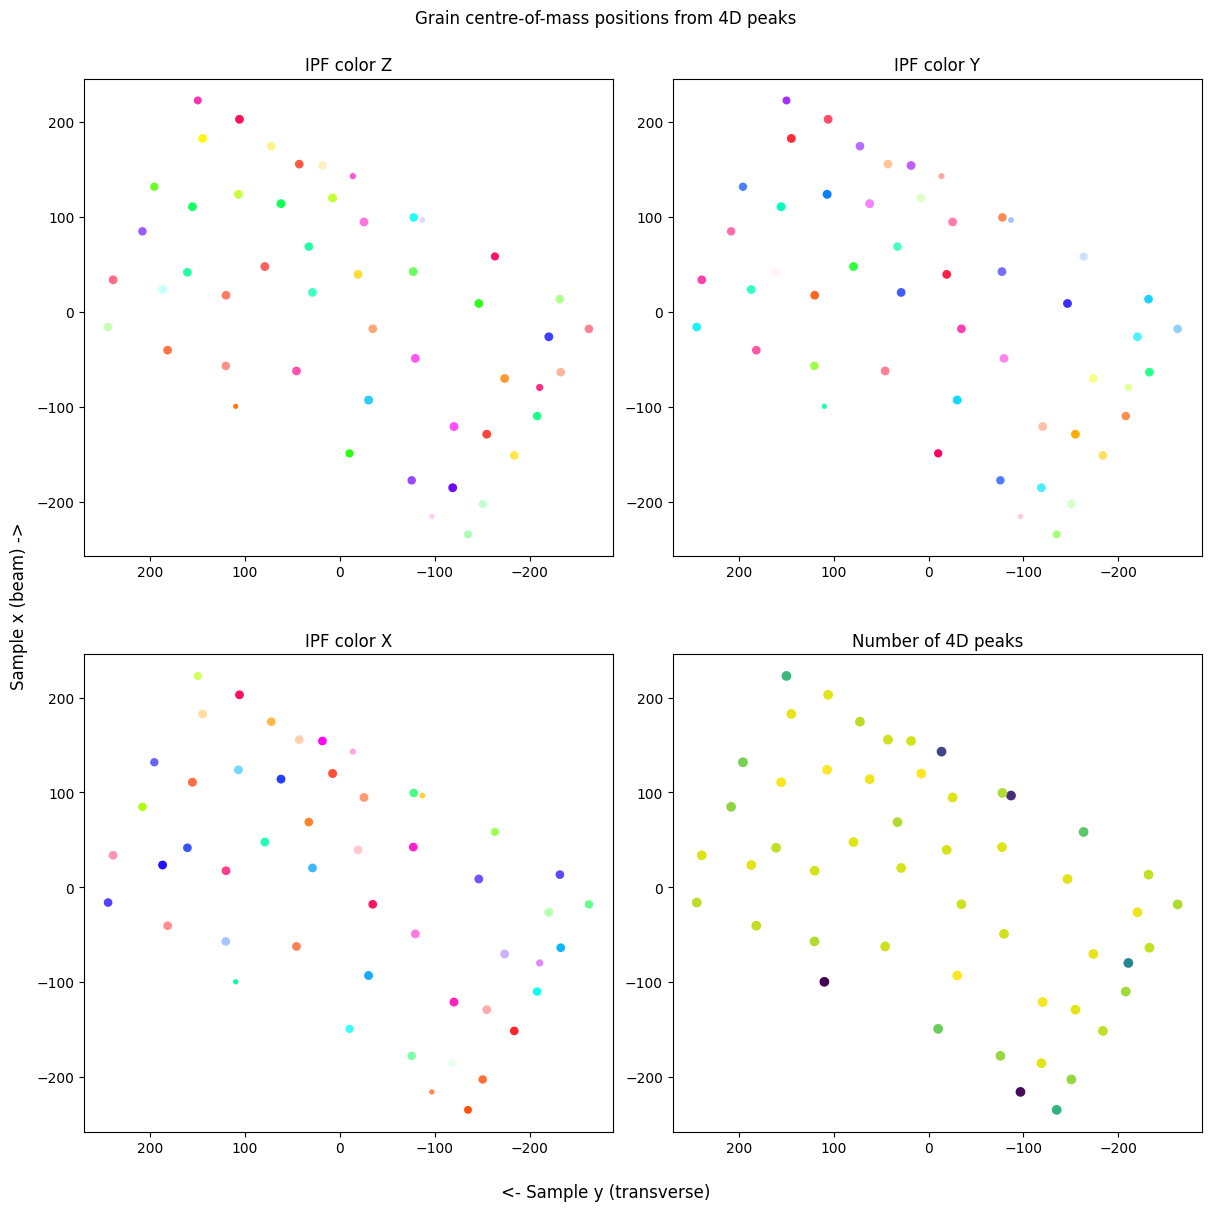

In [16]:
# plt.style.use('dark_background')
fig, ax = plt.subplots(2,2, figsize=(12,12), layout='constrained')
a = ax.ravel()
x = [g.translation[0] for g in grains]
y = [g.translation[1] for g in grains]
s = [g.npks_4d/10 for g in grains]
a[0].scatter(y, x, c=[g.rgb_z for g in grains], s=s)
a[0].set(title='IPF color Z',  aspect='equal')
a[1].scatter(y, x, c=[g.rgb_y for g in grains], s=s)
a[1].set(title='IPF color Y', aspect='equal')
a[2].scatter(y, x, c=[g.rgb_x for g in grains], s=s)
a[2].set(title='IPF color X',  aspect='equal')
a[3].scatter(y, x, c=s)
a[3].set(title='Number of 4D peaks', aspect='equal')
fig.supxlabel("<- Sample y (transverse)")
fig.supylabel("Sample x (beam) ->")
fig.suptitle("Grain centre-of-mass positions from 4D peaks")
for a in ax.ravel():
    a.invert_xaxis()
plt.show()

# $y_0$ refinement

During the experiment a physical motor is moving the sample across the beam. The center position of this motor is denoted $y_0$. This position is manually adjusted during the experiment to match with the center of the sample. 
To get a more precise position, it is possible to estimate $y_0$ from the centers of mass. Bear in mind that the fewer the number of grains, the worse the $y_0$ estimation.

This should be close to zero for the NSCOPE station, and somewhere around `14 mm` for the TDXRD station.

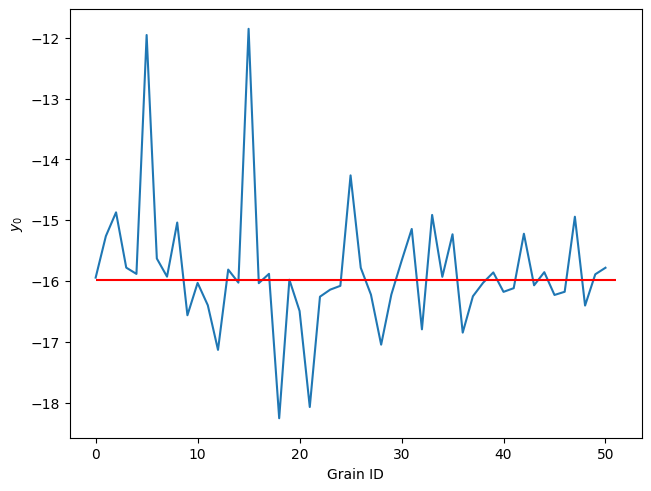

y0 is -15.979204998876389
shift is 8.489598935092346
pad is 18


In [17]:
sample_y0s = [gs.recon_y0 for gs in grainsinos]
y0 = np.median(sample_y0s)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(sample_y0s)
ax.hlines(y0, 0, len(grainsinos), color='red')
ax.set(xlabel='Grain ID', ylabel=r'$y_0$')
plt.show()
print('y0 is', y0)
if is_half_scan:
    ds.correct_bins_for_half_scan(y0=y0)
# try to automatically determine the sinogram shift and the padding from the y0 values
shift, pad = sino_shift_and_pad(y0, len(ds.ybincens), min(ds.ybincens), ds.ystep)
print('shift is', shift)
print('pad is', pad)
# update the grainsinogram parameters accordingly:
for gs in grainsinos:
    gs.update_recon_parameters(y0=y0, shift=shift, pad=pad)

# Whole-sample mask

Before reconstructing the grain shapes, it is important to mask areas without the sample. From the sinogram of all strong peaks, it is possible to reconstruct the overall shape of the sample. The mask can be drew interactively by clicking around the sample and closing the shape.

This should adequately differentiate between sample and air.

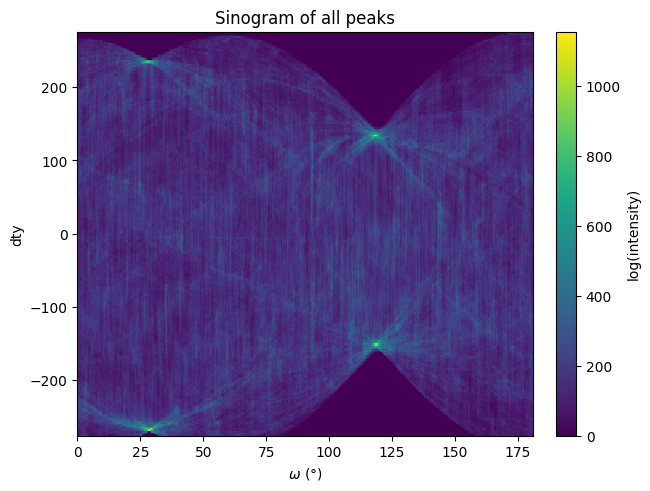

In [18]:
fig, ax = plt.subplots(layout='constrained')
whole_sample_sino, om_edges, dty_edges = ds.sinohist(np.log(ds.pk2d['sum_intensity']), ds.pk2d['omega'], ds.pk2d['dty'], return_edges=True)
whole_sample_sino = whole_sample_sino.T
pcm = ax.pcolormesh(om_edges, dty_edges, whole_sample_sino)
ax.set(xlabel=r'$\omega~(\degree)$', ylabel='dty', title='Sinogram of all peaks')
cax = fig.colorbar(pcm, ax=ax, label='log(intensity)')
plt.show()

In [19]:
nthreads = cImageD11.cores_available()
whole_sample_recon = run_iradon(whole_sample_sino, ds.obincens, pad, shift, workers=nthreads, apply_halfmask=is_half_scan, mask_central_zingers=is_half_scan)

In [20]:
draw_mask_interactive = False

In [21]:
# Now we generate a whole-sample mask for the image
if draw_mask_interactive:
    masker = InteractiveMask(whole_sample_recon)
else:
    # whole_sample_mask = threshold_mask(whole_sample_recon, manual_threshold=manual_threshold, doplot=True)
    whole_sample_mask = np.load('mask.npy')

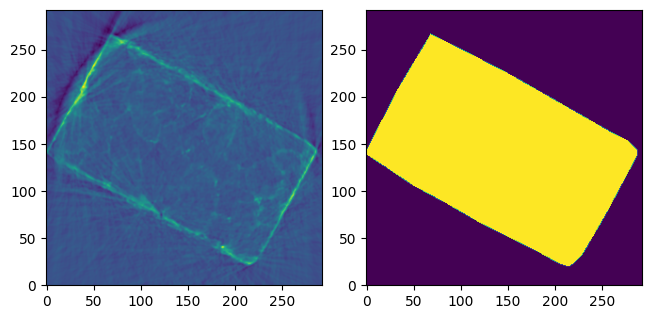

In [22]:
fig, ax = plt.subplots(1,2,layout='constrained')

ax[0].imshow(whole_sample_recon, origin = 'lower')

ax[1].imshow(whole_sample_mask, origin = 'lower')
plt.show()

In [23]:
if draw_mask_interactive:
    whole_sample_mask = masker.get_mask(doplot=True)

You can save the mask in *edf* or *npy* format if you wish to reload the same one for further experiements (if you scanned multiple layers in the vertical direction for instance).

- If you save the mask as *npy* format, when you load it, it will be a boolean array
- If you save the mask as *edf* format, when you load it, it will be 0 and 1 so you will have to convert it to boolean first

In [24]:
# import numpy as np
# np.save('mask.npy', whole_sample_mask)
# whole_sample_mask = np.load('mask.npy')

# import fabio
# obj = fabio.edfimage.EdfImage(data=whole_sample_mask)
# obj.write("mask.edf")

# whole_sample_mask = fabio.open('mask.edf').data.astype('bool')

# Grain sinogram generation

The goal is to reconstruct a sinogram for each grain

In [25]:
gord, inds = get_2d_peaks_from_4d_peaks(ds.pk2d, cf_strong)
for grain_label, gs in enumerate(tqdm(grainsinos)):
    gs.prepare_peaks_from_4d(cf_strong, gord, inds, grain_label, hkltol)

  0%|          | 0/51 [00:00<?, ?it/s]

^ if you segmented frelon data for scanning, the above cell won't work, because we don't have a 2d peaks table
you can instead try the below to prepare the peaks from the 2D peaks:

In [26]:
# cf_2d = ds.get_cf_2d_from_disk()
# ds.update_colfile_pars(cf_2d, phase_str)
# for grain_label, gs in enumerate(tqdm(grainsinos)):
#     gs.prepare_peaks_from_2d(cf_2d, grain_label, hkltol)

In [27]:
for gs in tqdm(grainsinos):
    gs.build_sinogram()

  0%|          | 0/51 [00:00<?, ?it/s]

In [28]:
# optionally correct the halfmask:
if is_half_scan:
    for gs in grainsinos:
        gs.correct_halfmask()

Display the sinogram of the first grain to see if it looks good.

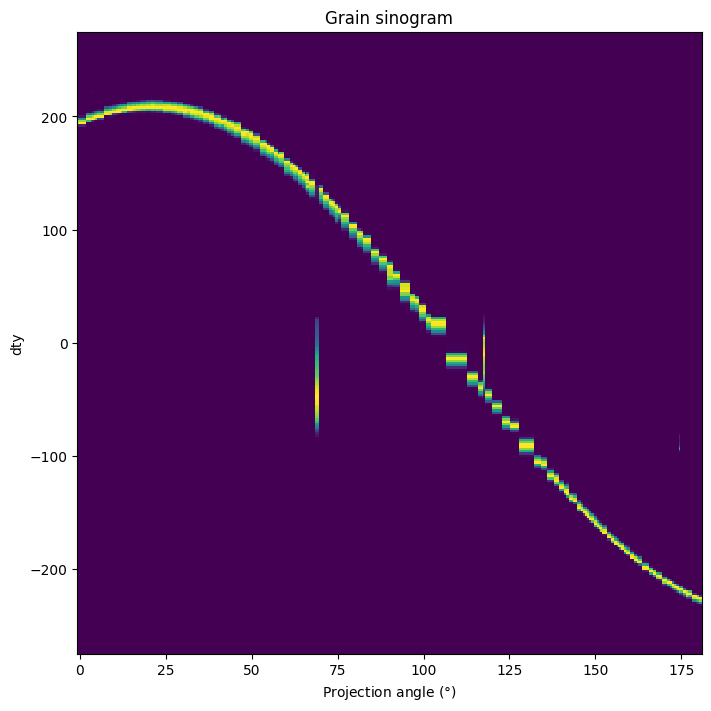

In [29]:
gs = grainsinos[0]
fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
ax.pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
ax.set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
plt.show()

We can optionally correct each row of the sinogram by the ring current of that rotation
This helps remove artifacts in the reconstruction

In [30]:
if correct_sinos_with_ring_current:
    ds.get_ring_current_per_scan()
    for gs in grainsinos:
        gs.correct_ring_current(is_half_scan=is_half_scan)

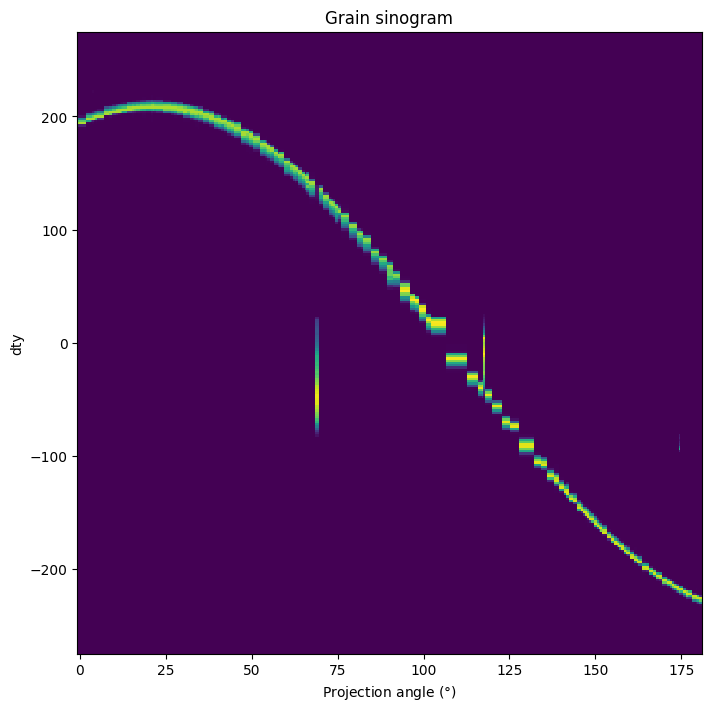

In [31]:
gs = grainsinos[0]
fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
ax.pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
ax.set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
plt.show()

# Grain shape reconstruction

By back projecting a sinogram, it is possible to reconstruct the 2D shape of each grain (same principle as tomographic imaging). There are different method to do a back projection, the fastest is using *iradon* from the scipy library.

## iradon
### First grain as example
Check that the reconstruction is satisfying for the first grain. 
There should be a sinogram on the left picture and a reconstruction of the grain on the right. Sometimes the first grain is a very small one, it's okay, streaks might appear on the reconstruction. They will disappear when we will use Astra to reconstruct the grains.

A sign of a bad reconstruction is a completely dark picture. In that case, you might want to check that the mask is correctly loaded (and that it's boolean, True/False, and not 0 and 1):
```
plt.figure()
plt.imshow(whole_sample_mask)
```

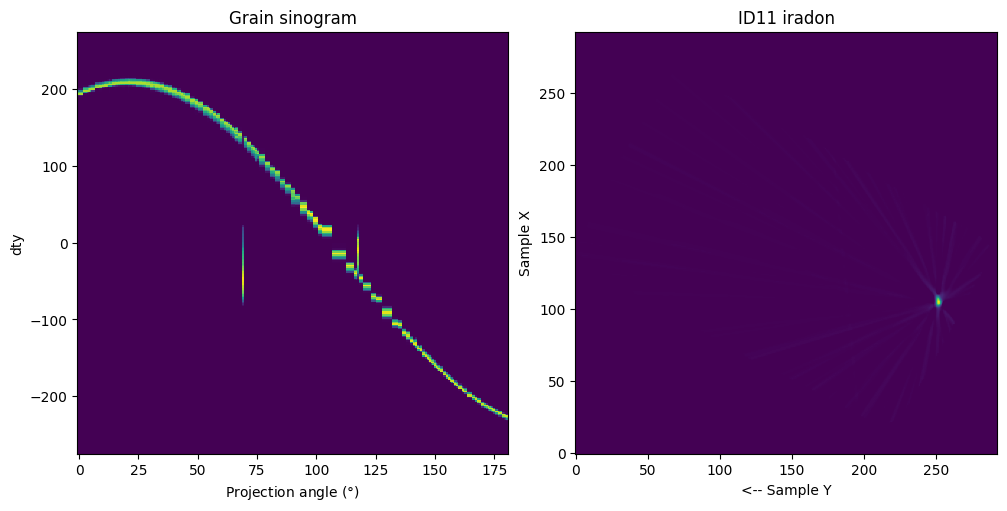

In [32]:
gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, y0=y0)
gs.recon()
if is_half_scan:
    gs.mask_central_zingers("iradon", radius=halfmask_radius)
fig, axs = plt.subplots(1,2, figsize=(10,5), layout="constrained")
axs[0].pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
axs[0].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
axs[1].imshow(gs.recons["iradon"], vmin=0, origin="lower")
axs[1].set(title="ID11 iradon", xlabel="<-- Sample Y", ylabel="Sample X")
plt.show()

For every grain, we update the reconstruction parameters : 
- `pad`
- `shift`
- `whole_sample_mask`
- `y0`

In [33]:
for gs in grainsinos:
    gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, y0=y0)

### Reconstruct all grains
In parallel, on as many cpu you have available.

In [34]:
with concurrent.futures.ThreadPoolExecutor(max_workers= max(1,nthreads-1)) as pool:
    for i in tqdm(pool.map(GrainSinogram.recon, grainsinos), total=len(grainsinos)):
        pass
if is_half_scan:
    for gs in grainsinos:
        gs.mask_central_zingers("iradon", radius=halfmask_radius)

  0%|          | 0/51 [00:00<?, ?it/s]

### View outputs
You can slide the widget to go through all the reconstructed grains.
If some grains look messy (lots of streak), it's okay, the next reconstruction method Astra will give better results.

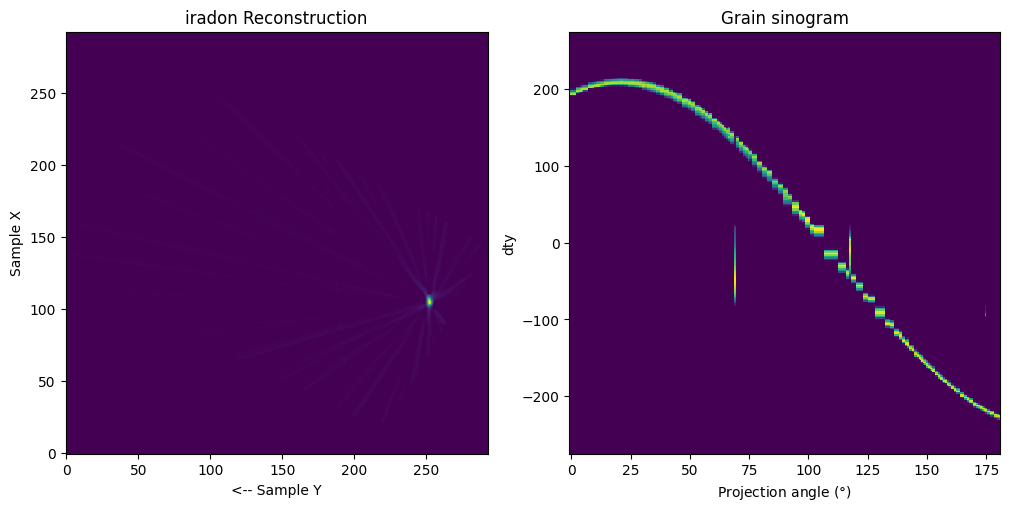

interactive(children=(IntSlider(value=0, description='Grain:', max=50), Output()), _dom_classes=('widget-inter…

In [35]:
def update_frame(i):
    rec.set_array(grainsinos[i].recons["iradon"])
    sin = a[1].pcolormesh(grainsinos[i].sinoangles, ds.ybincens, grainsinos[i].ssino)
    fig.suptitle("Grain " + str(i))
    fig.canvas.draw()
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(grains) - 1,
    step=1,
    description='Grain:'
)
fig, a = plt.subplots(1,2,figsize=(10,5), constrained_layout=True)
rec = a[0].imshow(grainsinos[0].recons["iradon"], vmin=0, origin="lower")
sin = a[1].pcolormesh(grainsinos[0].sinoangles, ds.ybincens, grainsinos[0].ssino)
a[0].set(xlabel="<-- Sample Y", ylabel="Sample X", title="iradon Reconstruction")
a[1].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
widgets.interact(update_frame, i=frame_slider)
plt.show()

### Assemble TensorMap

All the grains are assembled together on a single map

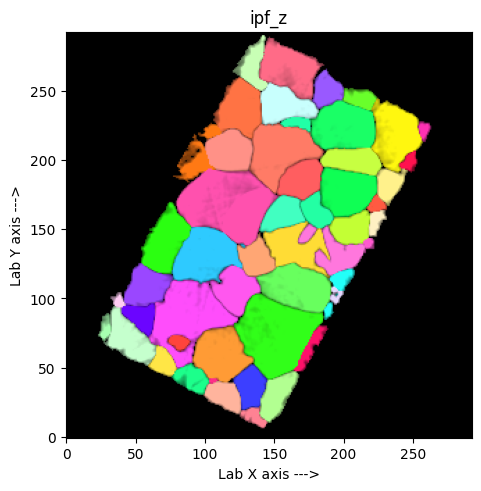

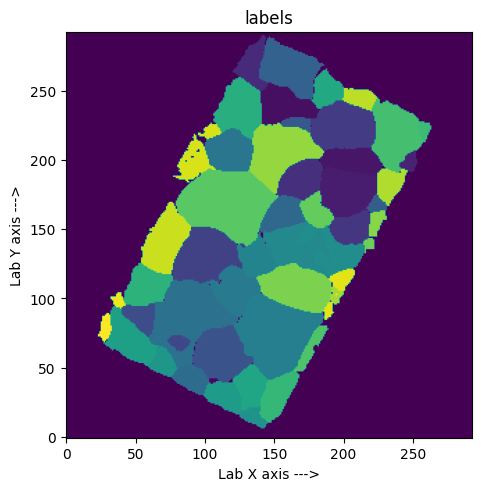

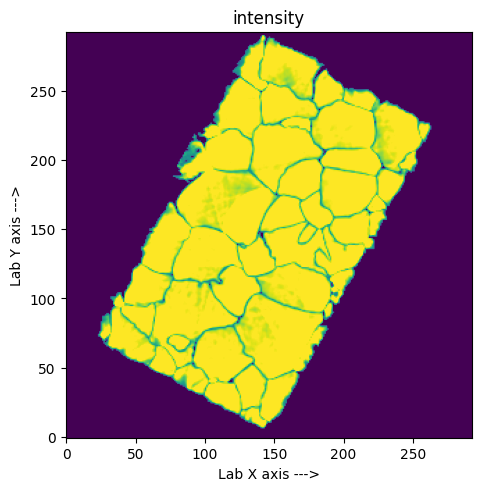

In [36]:
tensor_map = TensorMap.from_grainsinos(grainsinos, cutoff_level=first_tmap_cutoff_level)
tensor_map.plot("ipf_z")
tensor_map.plot("labels")
tensor_map.plot("intensity")

## ASTRA
We can clean up these reconstructions using an MLEM (maximum likelyhoo expectation maimization) iterative recon.  
We will carry this out using ASTRA (https://astra-toolbox.com/) on the GPU on the SLURM cluster.  
The ASTRA EM_CUDA method will be used.

In [37]:
for gs in grainsinos:
    gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, niter=niter, y0=y0)
write_h5(ds.grainsfile, grainsinos, overwrite_grains=True, group_name=phase_str)

Submit the batch file to the ESRF cluster

In [38]:
bash_script_path = utils.prepare_astra_bash(ds, ds.grainsfile, PYTHONPATH, group_name=phase_str)
utils.slurm_submit_and_wait(bash_script_path, 10)

Submitted batch job 25118526
25118526
Slurm job not finished! Waiting 10 seconds...


Slurm job not finished! Waiting 10 seconds...


Slurm job not finished! Waiting 10 seconds...


KeyboardInterrupt: 

In [39]:
grainsinos = read_h5(ds.grainsfile, ds, group_name=phase_str)
for gs, g in zip(grainsinos, grains):
    gs.grain = g
    gs.ds = ds

### View outputs

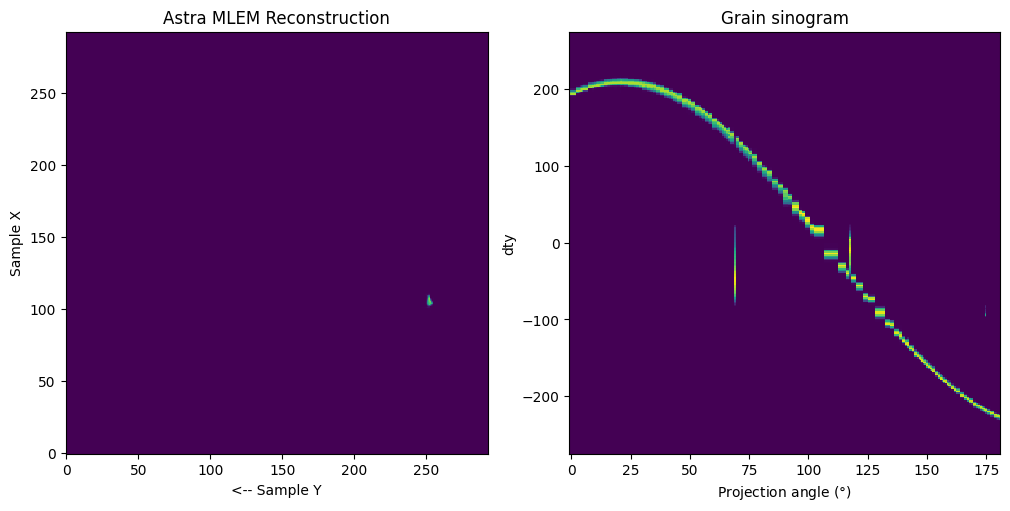

interactive(children=(IntSlider(value=0, description='Grain:', max=50), Output()), _dom_classes=('widget-inter…

In [40]:
def update_frame(i):
    rec.set_array(grainsinos[i].recons["iradon"])
    sin = a[1].pcolormesh(grainsinos[i].sinoangles, ds.ybincens, grainsinos[i].ssino)
    fig.suptitle("Grain " + str(i))
    fig.canvas.draw()
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(grains) - 1,
    step=1,
    description='Grain:'
)
fig, a = plt.subplots(1,2,figsize=(10,5), constrained_layout=True)
rec = a[0].imshow(grainsinos[0].recons["astra"], vmin=0, origin="lower")
sin = a[1].pcolormesh(grainsinos[0].sinoangles, ds.ybincens, grainsinos[0].ssino)
a[0].set(xlabel="<-- Sample Y", ylabel="Sample X", title="Astra MLEM Reconstruction")
a[1].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
widgets.interact(update_frame, i=frame_slider)
plt.show()

### Assemble TensorMap

Once again all the ASTRA reconstructed grains are assembled together in a tensormap object.

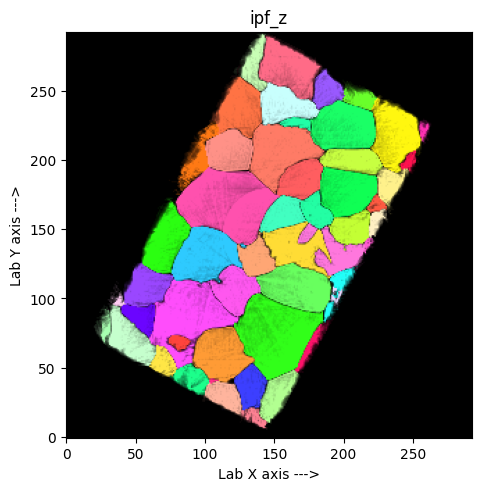

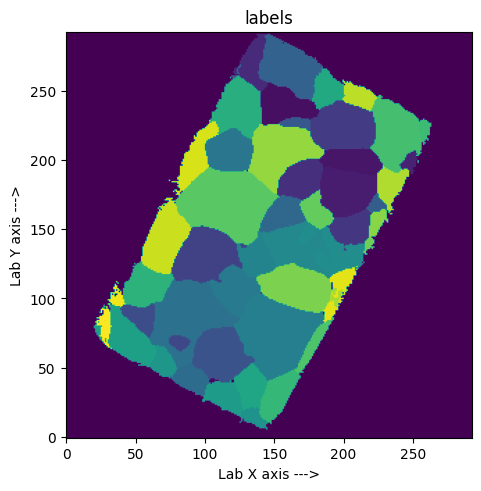

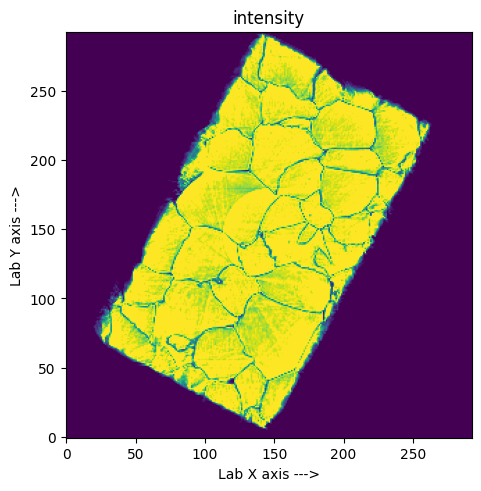

In [41]:
tensor_map_astra = TensorMap.from_grainsinos(grainsinos, cutoff_level=second_tmap_cutoff_level, method="astra")
tensor_map_astra.plot("ipf_z")
tensor_map_astra.plot("labels")
tensor_map_astra.plot("intensity")

# Export

If the reconstruction is satisfying, we can save everything to the grain file (*XXX_grains.h5*).
## Grains

In [42]:
write_h5(ds.grainsfile, grainsinos, overwrite_grains=True, group_name=phase_str)

## TensorMap

If you already ran this notebook once and saved some results, you can not overwrite them.
This will inevitably lead to an error like : 
```
ValueError: Unable to synchronously create group (name already exists)
```

In that case, you can delete the existing grains with these lines of code below.


In [43]:
from ImageD11.forward_model import io
io.delete_group_from_h5(ds.grainsfile, group_name = 'TensorMap_' + phase_str)

True

In [44]:
tensor_map_astra.to_h5(ds.grainsfile, h5group='TensorMap_' + phase_str)

## XDMF

In [45]:
tensor_map_astra.to_paraview(ds.grainsfile, h5group='TensorMap_' + phase_str)

In [46]:
ds.save()